# Twitter Sentiment Analysis

In [71]:
import pandas as pd
import numpy as np


import regex as re
import emoji
from nltk.stem.snowball import SnowballStemmer
import re ,string, unicodedata, html 
import nltk
from nltk import word_tokenize , WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from keras_preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [69]:
# Uploading the datstet
drive.mount('/content/drive/')
%cd drive/My Drive/TextDataset
train_data = pd.read_csv("Tweets_train.csv")
val_data = pd.read_csv("Tweets_dev.csv")
test_data = pd.read_csv("Tweets_test.csv", encoding = "iso-8859-1")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/TextDataset'
/content/drive/My Drive/TextDataset


In [3]:
train_data.head()

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,positive
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive
3,569525116725567491,@USAirways The automated message isn't helpful...,negative
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive


In [4]:
# Row and Columns

print("Train Dataset Shape : ", train_data.shape)
print("Validation Dataset Shape : ", val_data.shape)
print("Test Dataset Shape : ", test_data.shape)

Train Dataset Shape :  (11858, 3)
Validation Dataset Shape :  (1318, 3)
Test Dataset Shape :  (1464, 3)


In [5]:
# Dataset Information

print(f"Train Dataset : \n")
print(train_data.info())
print(f"\n\nValidation Dataset : \n")
print(val_data.info())
print(f"\n\nTest Dataset : \n")
print(test_data.info())

Train Dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11858 entries, 0 to 11857
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           11858 non-null  int64 
 1   text               11858 non-null  object
 2   airline_sentiment  11858 non-null  object
dtypes: int64(1), object(2)
memory usage: 278.0+ KB
None


Validation Dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           1318 non-null   int64 
 1   text               1318 non-null   object
 2   airline_sentiment  1318 non-null   object
dtypes: int64(1), object(2)
memory usage: 31.0+ KB
None


Test Dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 3 columns):
 #   Column             Non-Null Co

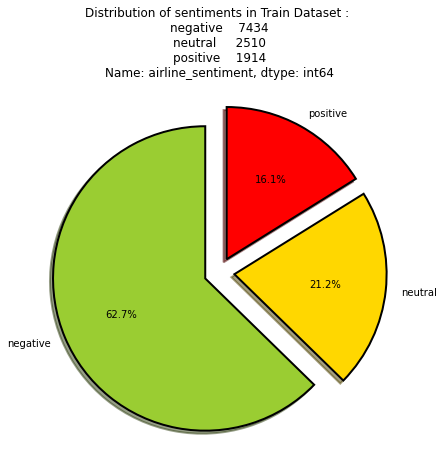

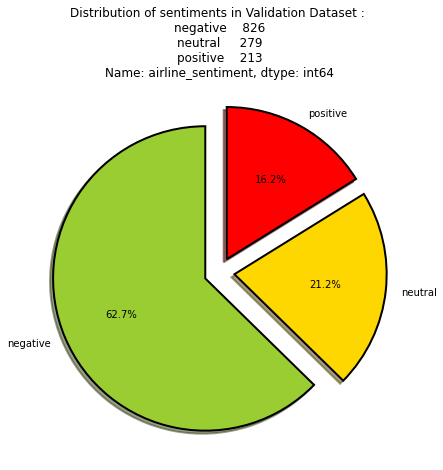

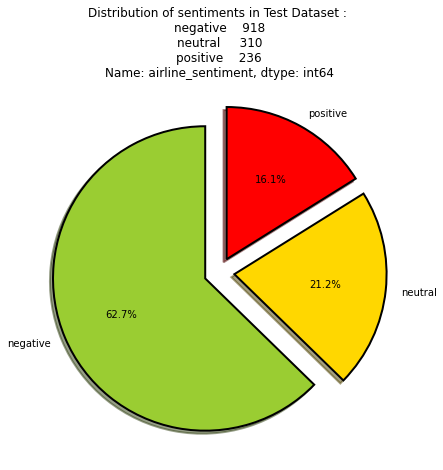

In [6]:
# Distribution of sentiments

datasets = [train_data, val_data, test_data]

for i, data in enumerate(datasets):
    tags = data['airline_sentiment'].value_counts()
    explode = (0.1,0.1,0.1)
    colors = ("yellowgreen", "gold", "red")
    wp = {'linewidth':2, 'edgecolor':"black"}
    fig = plt.figure(figsize=(7,7))
    tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
             startangle=90, wedgeprops = wp, explode = explode, label='')
    if i==0:
        plt.title(f'Distribution of sentiments in Train Dataset : \n{tags}')
    elif i==1:
        plt.title(f'Distribution of sentiments in Validation Dataset : \n{tags}')
    else:
        plt.title(f'Distribution of sentiments in Test Dataset : \n{tags}')
        
    plt.show()

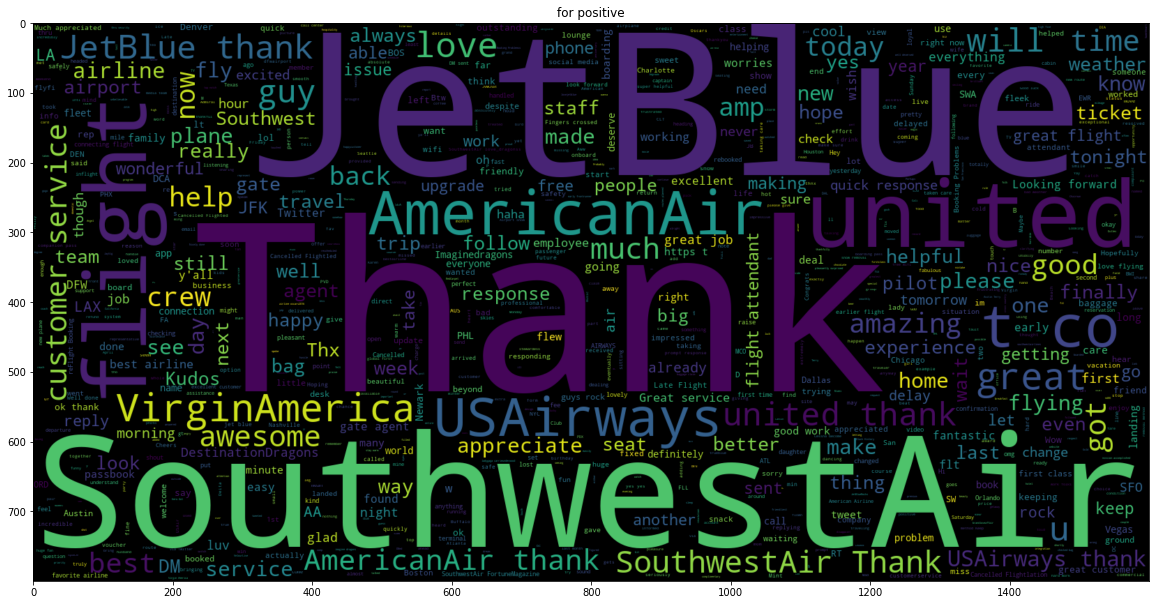

In [72]:
# Positive
plt.figure(figsize = (20,20))
plt. grid(False) 
plt.title("for positive")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(train_data[train_data.airline_sentiment == 'positive'].text.str.cat(sep=' '))
plt.imshow(wc , interpolation = 'bilinear')

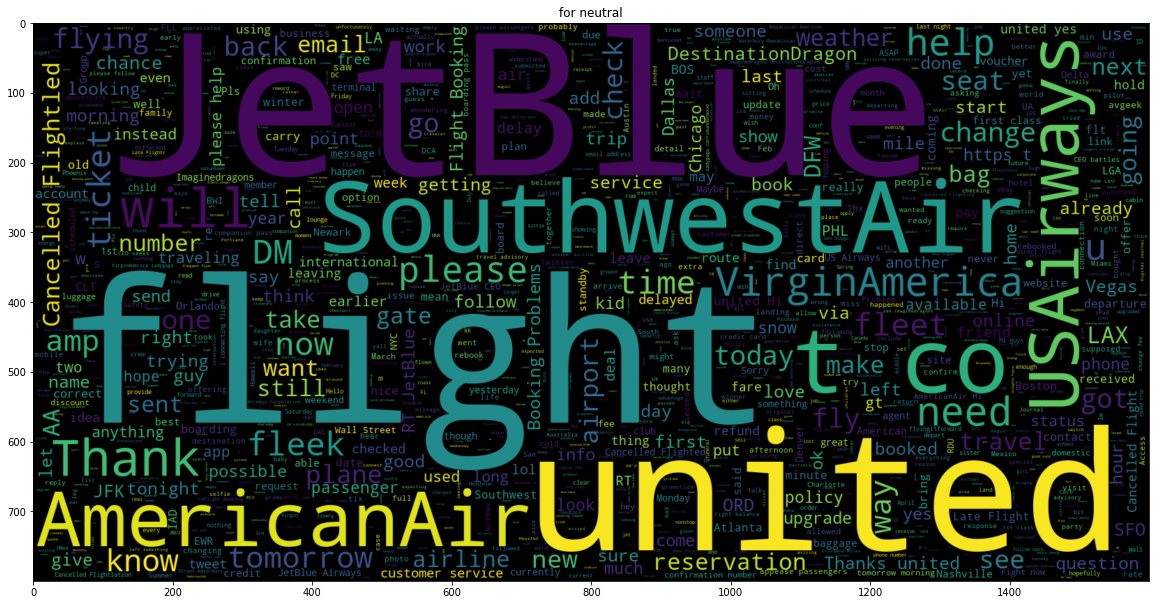

In [73]:
# Neutral
plt.figure(figsize = (20,20))
plt. grid(False) 
plt.title("for neutral")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(train_data[train_data.airline_sentiment == 'neutral'].text.str.cat(sep=' '))
plt.imshow(wc , interpolation = 'bilinear')

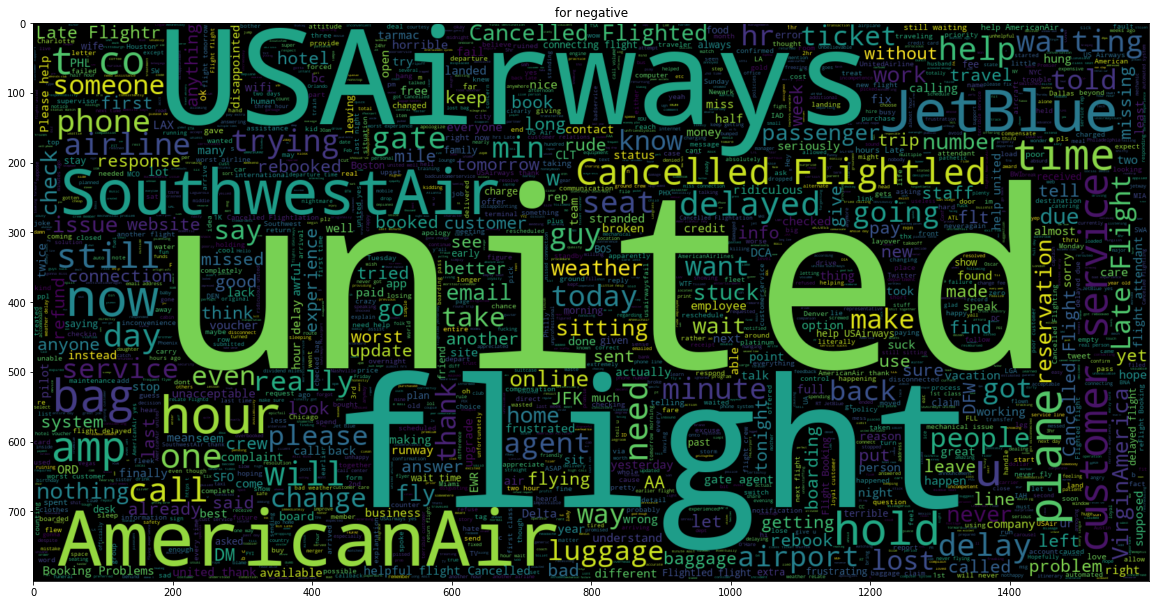

In [74]:
# Negative
from wordcloud import WordCloud
plt.figure(figsize = (20,20))
plt. grid(False) 
plt.title("for negative")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(train_data[train_data.airline_sentiment == 'negative'].text.str.cat(sep=' '))
plt.imshow(wc , interpolation = 'bilinear')

In [75]:
### Checking Dupicates in Dataset

print('Train Data :',train_data.duplicated().sum())
print('Val Data :',val_data.duplicated().sum())
print('Test Data :',test_data.duplicated().sum())

Train Data : 91
Val Data : 1
Test Data : 9


In [8]:
### Checking isnull in Dataset

print('Train Data :',train_data.isnull().sum())
print('Val Data :',val_data.isnull().sum())
print('Test Data :',test_data.isnull().sum())

Train Data : tweet_id             0
text                 0
airline_sentiment    0
dtype: int64
Val Data : tweet_id             0
text                 0
airline_sentiment    0
dtype: int64
Test Data : tweet_id             0
text                 0
airline_sentiment    0
dtype: int64


In [76]:
class Preprocessor:
    def __init__(self, stopword = set(stopwords.words('english'))):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=5, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopword = set(stopwords.words('english'))
        self.vectorizer_fitted = False

    def lowcase(self,texts):
        print('Lowering...')
        return [text.lower() for text in texts]

    def decode_emojis(self, texts):
        print('Decoding emojis...')
        texts = [emoji.demojize(text, language='en') for text in texts] 
        return texts

    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, ' ', text) for text in texts]

    def remove_hastags(self, texts):
        print('Removing Hashtag...')
        pattern = re.compile('#[A-Za-z0-9_]+|[A-Za-z0-9_]+#')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_usermentions (self, texts):
        print('Removing User Mentions...')
        #pattern = re.compile('@[A-Za-z0-9_]+')
        pattern = re.compile(r"(@\w+)?(?<=\s)(?!@united|@jetblue|@americanair|@delta|@virginamerica|@usairways|@southwestair)@\w+(?=\s|:|\.)")
        #pattern = re.compile(r"(@united|@jetblue|@americanair|@delta|@virginamerica|@usairways|@southwestair)")
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_wordswithnumbers (self, texts):
        print('Removing words with numbers...')
        pattern = re.compile('\w*\d\w*')
        #pattern = re.compile('\d+')
        return [re.sub(pattern, ' ', text) for text in texts]

    def decontraction(self, texts):
        texts = [re.sub(r"\n", "", text) for text in texts]
        texts = [re.sub("\'", "'", text) for text in texts]
        texts = [re.sub(r"won't", " will not", text) for text in texts]
        texts = [re.sub(r"won't've", " will not have", text) for text in texts]
        texts = [re.sub(r"can't", " can not", text) for text in texts]
        texts = [re.sub(r"don't", " do not", text) for text in texts]
        texts = [re.sub(r"can't've", " can not have", text) for text in texts]
        texts = [re.sub(r"ma'am", " madam", text) for text in texts]
        texts = [re.sub(r"let's", " let us", text) for text in texts]
        texts = [re.sub(r"ain't", " am not", text) for text in texts]
        texts = [re.sub(r"shan't", " shall not", text) for text in texts]
        texts = [re.sub(r"y'all", " you all", text) for text in texts]
        texts = [re.sub(r"n't", " not", text) for text in texts]
        texts = [re.sub(r"n't've", " not have", text) for text in texts]
        texts = [re.sub(r"'re", " are", text) for text in texts]
        texts = [re.sub(r"'s", " is", text) for text in texts]
        texts = [re.sub(r"'d", " would", text) for text in texts]
        texts = [re.sub(r"'d've", " would have", text) for text in texts]
        texts = [re.sub(r"'ll", " will", text) for text in texts]
        texts = [re.sub(r"'ll've", " will have", text) for text in texts]
        texts = [re.sub(r"'t", " not", text) for text in texts]
        texts = [re.sub(r"'ve", " have", text) for text in texts]
        texts = [re.sub(r"'m", " am", text) for text in texts]
        texts = [re.sub(r"'re", " are", text) for text in texts]
        texts = [re.sub("\s(hr)", " hour", text) for text in texts]
        texts = [re.sub(r"\s(min)", " minute", text) for text in texts]
        #texts = [re.sub(r"iove", "love", text) for text in texts]
        texts = [re.sub("\s(svc)\s", " service", text) for text in texts]
        texts = [re.sub("\s(cust)\s", " customer", text) for text in texts]
        texts = [re.sub("customer service", " service", text) for text in texts]
        texts = [re.sub("customer service line", " service", text) for text in texts]
        texts = [re.sub("\s(ur)\s", " your", text) for text in texts]
        texts = [re.sub(r"comp'd", "compared", text) for text in texts]
        texts = [re.sub("\s(yep)", "yes", text) for text in texts]
        texts = [re.sub("\s(yr)", "year", text) for text in texts]
        #texts = [re.sub(r"jet blue", "jetblue", text) for text in texts]
        texts = [re.sub(r"&amp", "&", text) for text in texts]
        
        return texts

    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        new_texts = list()
        word =  [["".join(w) for w in text.split(' ') if w not in stopwords.words('english')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile("[^A-Za-z]")
        return [re.sub(pattern, " ", text) for text in texts]

    def lemmatize_words(self, texts):
        print('Lemmatizing words in text...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w)) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def lemmatize_verb(self, texts):
        print('Lemmatizing...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w, pos='v')) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def lemmatize_noun(self, texts):
        print('Lemmatizing...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w, pos='n')) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def stemming(self, texts):
        print('Stemming...')
        stemmer = SnowballStemmer('english')
        new_texts = list()
        word = [["".join(stemmer.stem(w)) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]
    
    def remove_multiplespace(self, texts):
        print('Removing Multi Space...')
        pattern = re.compile(r'\s+')
        return [re.sub(pattern, " ", text) for text in texts]

    def remove_singleletter(self, texts):
        print('Removing Single letter...')
        pattern = re.compile(r'\s+[a-zA-Z]\s+|\^[a-zA-Z]\s+')
        return [re.sub(pattern, " ", text) for text in texts]

    def convert_sentiment(self, texts):
        sen_encoded = list()
        for sentiment in texts:
            if  sentiment == "positive":
                sen_encoded.append(2)
            elif sentiment == "neutral":
                sen_encoded.append(1)
            elif sentiment == "negative":
                sen_encoded.append(0)
        return pd.Series(sen_encoded, name = "airline_sentiment")
    
    def transform(self, X=None, y=None, mode='train', vectorise = True):
        if (X is None):
            y = self.convert_sentiment(y)
            return y
        else:
            
            print('Removing Nans...')
            X = X[~X.isnull()]                          # delete nans
            X = X[~X.duplicated()]                      # delete duplicates

            if mode == 'train':
                self.train_idx = X.index
            elif mode == 'val':
                self.val_idx = X.index
            else:
                self.test_idx = X.index


            X = self.lowcase(X)
            X = self.decode_emojis(X)
            X = self.remove_urls(X)
            X = self.remove_hastags(X)
            X = self.remove_usermentions(X)
            X = self.remove_wordswithnumbers(X)
            X = self.decontraction(X)
            X = self.remove_stopwords(X)
            X = self.remove_punctuation(X)
            #X = self.lemmatize_words(X)
            X = self.lemmatize_noun(X)
            X = self.lemmatize_verb(X)
            #X = self.stemming(X)
            X = self.remove_multiplespace(X)
            X = self.remove_singleletter(X)


            if (vectorise == True):
                if not self.vectorizer_fitted:
                    self.vectorizer_fitted = True
                    print('Fitting vectorizer...')
                    self.vectorizer.fit(X)
    
                print('Vectorizing...')
                X = self.vectorizer.transform(X)   
            return X


In [77]:
# Preprocess data
pr = Preprocessor()
X_train = pr.transform(X = train_data['text'], y = None)
X_val = pr.transform(X = val_data['text'], mode = 'val', y = None)
X_test = pr.transform(X = test_data['text'], mode = 'test', y = None)


y_train = pr.transform(y = train_data['airline_sentiment'], X = None)
y_val = pr.transform(y = val_data['airline_sentiment'], X = None)
y_test = pr.transform(y = test_data['airline_sentiment'], X = None)

Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 11858/11858 [00:35<00:00, 335.83it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 11858/11858 [00:00<00:00, 13738.89it/s]


Lemmatizing...


100%|██████████| 11858/11858 [00:00<00:00, 13854.40it/s]


Removing Multi Space...
Removing Single letter...
Fitting vectorizer...
Vectorizing...
Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 1318/1318 [00:02<00:00, 452.65it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 1318/1318 [00:00<00:00, 13960.61it/s]


Lemmatizing...


100%|██████████| 1318/1318 [00:00<00:00, 13954.72it/s]


Removing Multi Space...
Removing Single letter...
Vectorizing...
Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 1464/1464 [00:03<00:00, 459.83it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 1464/1464 [00:00<00:00, 13497.89it/s]


Lemmatizing...


100%|██████████| 1464/1464 [00:00<00:00, 14715.41it/s]

Removing Multi Space...
Removing Single letter...
Vectorizing...


In [78]:
# update the datatype

X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns=pr.vectorizer.get_feature_names_out())
y_train = y_train[y_train.index.isin(pr.train_idx)]
y_train.index = X_train.index

X_val = pd.DataFrame.sparse.from_spmatrix(X_val, columns=pr.vectorizer.get_feature_names_out())
y_val = y_val[y_val.index.isin(pr.val_idx)]
y_val.index = X_val.index

X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns=pr.vectorizer.get_feature_names_out())
y_test = y_test[y_test.index.isin(pr.test_idx)]
y_test.index = X_test.index

# Model 1 - Logistic Regression

In [ ]:
def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        return_train_score=True,
                        scoring = scoring,
                        n_jobs=-1,
                        verbose=2,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [13]:
rs_parameters = {
    'penalty': ['elasticnet', 'l2', 'l1'],
    'C': uniform(scale = 10),
    'solver': ['saga', 'sag', 'newton-cg', 'liblinear', 'lbfgs'],
    'l1_ratio' : uniform(scale = 1)
    }

lr = LogisticRegression()
model_cv_lr = train_cv(lr, X_train, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params {'C': 4.17022004702574, 'l1_ratio': 0.7203244934421581, 'penalty': 'l2', 'solver': 'liblinear'}


In [14]:
print(accuracy_score(y_test, bestimator_lr.predict(X_test)))

0.7957359009628611


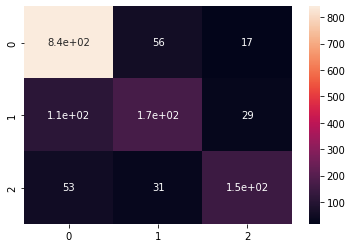

In [15]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()

# Model2 - VotingClassifier (Ensemble)

In [16]:
# For the sake of SVC model
X_train1 = X_train.to_numpy()
X_test1 = X_test.to_numpy()

In [17]:
# Create the individual classifiers
clf1 = MultinomialNB()
clf2 = SVC(kernel='linear', probability=True)
clf3 = LogisticRegression()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('nb', clf1), ('svc', clf2), ('lr', clf3)], voting='soft')

# Fit the ensemble classifier to the training data
ensemble.fit(X_train1, y_train)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('svc', SVC(kernel='linear', probability=True)),
                             ('lr', LogisticRegression())],
                 voting='soft')

In [18]:
# Evaluate the ensemble classifier on the test data
y_pred = ensemble.predict(X_test1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.7902338376891335


In [19]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       914
           1       0.69      0.48      0.57       309
           2       0.78      0.60      0.68       231

    accuracy                           0.79      1454
   macro avg       0.76      0.67      0.71      1454
weighted avg       0.78      0.79      0.78      1454



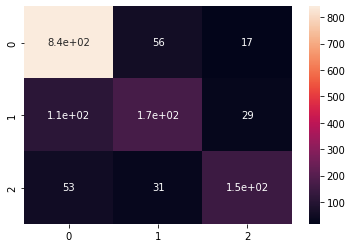

In [20]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()

# Model 3 - XGBoost Classifier

In [32]:
xgb = XGBClassifier()
xgb.fit(X_train1,y_train)


XGBClassifier(objective='multi:softprob')

In [34]:
print(accuracy_score(y_test, xgb.predict(X_test1)))

0.7379642365887208


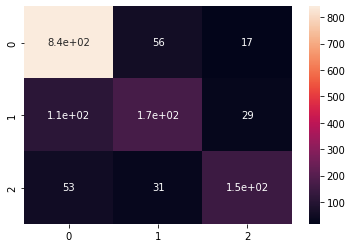

In [35]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()

# Model 4 - ANN

In [79]:
class Preprocessor:
    def __init__(self, stopword = set(stopwords.words('english'))):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=5, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopword = set(stopwords.words('english'))
        self.vectorizer_fitted = False

    def lowcase(self,texts):
        print('Lowering...')
        return [text.lower() for text in texts]

    def decode_emojis(self, texts):
        print('Decoding emojis...')
        texts = [emoji.demojize(text, language='en') for text in texts] 
        return texts

    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, ' ', text) for text in texts]

    def remove_hastags(self, texts):
        print('Removing Hashtag...')
        pattern = re.compile('#[A-Za-z0-9_]+|[A-Za-z0-9_]+#')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_usermentions (self, texts):
        print('Removing User Mentions...')
        #pattern = re.compile('@[A-Za-z0-9_]+')
        pattern = re.compile(r"(@\w+)?(?<=\s)(?!@united|@jetblue|@americanair|@delta|@virginamerica|@usairways|@southwestair)@\w+(?=\s|:|\.)")
        #pattern = re.compile(r"(@united|@jetblue|@americanair|@delta|@virginamerica|@usairways|@southwestair)")
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_wordswithnumbers (self, texts):
        print('Removing words with numbers...')
        pattern = re.compile('\w*\d\w*')
        #pattern = re.compile('\d+')
        return [re.sub(pattern, ' ', text) for text in texts]

    def decontraction(self, texts):
        texts = [re.sub(r"\n", "", text) for text in texts]
        texts = [re.sub("\'", "'", text) for text in texts]
        texts = [re.sub(r"won't", " will not", text) for text in texts]
        texts = [re.sub(r"won't've", " will not have", text) for text in texts]
        texts = [re.sub(r"can't", " can not", text) for text in texts]
        texts = [re.sub(r"don't", " do not", text) for text in texts]
        texts = [re.sub(r"can't've", " can not have", text) for text in texts]
        texts = [re.sub(r"ma'am", " madam", text) for text in texts]
        texts = [re.sub(r"let's", " let us", text) for text in texts]
        texts = [re.sub(r"ain't", " am not", text) for text in texts]
        texts = [re.sub(r"shan't", " shall not", text) for text in texts]
        texts = [re.sub(r"y'all", " you all", text) for text in texts]
        texts = [re.sub(r"n't", " not", text) for text in texts]
        texts = [re.sub(r"n't've", " not have", text) for text in texts]
        texts = [re.sub(r"'re", " are", text) for text in texts]
        texts = [re.sub(r"'s", " is", text) for text in texts]
        texts = [re.sub(r"'d", " would", text) for text in texts]
        texts = [re.sub(r"'d've", " would have", text) for text in texts]
        texts = [re.sub(r"'ll", " will", text) for text in texts]
        texts = [re.sub(r"'ll've", " will have", text) for text in texts]
        texts = [re.sub(r"'t", " not", text) for text in texts]
        texts = [re.sub(r"'ve", " have", text) for text in texts]
        texts = [re.sub(r"'m", " am", text) for text in texts]
        texts = [re.sub(r"'re", " are", text) for text in texts]
        texts = [re.sub("\s(hr)", " hour", text) for text in texts]
        texts = [re.sub(r"\s(min)", " minute", text) for text in texts]
        #texts = [re.sub(r"iove", "love", text) for text in texts]
        texts = [re.sub("\s(svc)\s", " service", text) for text in texts]
        texts = [re.sub("\s(cust)\s", " customer", text) for text in texts]
        texts = [re.sub("customer service", " service", text) for text in texts]
        texts = [re.sub("customer service line", " service", text) for text in texts]
        texts = [re.sub("\s(ur)\s", " your", text) for text in texts]
        texts = [re.sub(r"comp'd", "compared", text) for text in texts]
        texts = [re.sub("\s(yep)", "yes", text) for text in texts]
        texts = [re.sub("\s(yr)", "year", text) for text in texts]
        #texts = [re.sub(r"jet blue", "jetblue", text) for text in texts]
        texts = [re.sub(r"&amp", "&", text) for text in texts]
        
        return texts

    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        new_texts = list()
        word =  [["".join(w) for w in text.split(' ') if w not in stopwords.words('english')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile("[^A-Za-z]")
        return [re.sub(pattern, " ", text) for text in texts]

    def lemmatize_words(self, texts):
        print('Lemmatizing words in text...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w)) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def lemmatize_verb(self, texts):
        print('Lemmatizing...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w, pos='v')) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def lemmatize_noun(self, texts):
        print('Lemmatizing...')
        lemmatizer = WordNetLemmatizer()
        new_texts = list()
        word = [["".join(lemmatizer.lemmatize(w, pos='n')) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]

    def stemming(self, texts):
        print('Stemming...')
        stemmer = SnowballStemmer('english')
        new_texts = list()
        word = [["".join(stemmer.stem(w)) for w in text.split(' ')] for text in tqdm(texts)]
        return [" ".join(i) for i in word]
    
    def remove_multiplespace(self, texts):
        print('Removing Multi Space...')
        pattern = re.compile(r'\s+')
        return [re.sub(pattern, " ", text) for text in texts]

    def remove_singleletter(self, texts):
        print('Removing Single letter...')
        pattern = re.compile(r'\s+[a-zA-Z]\s+|\^[a-zA-Z]\s+')
        return [re.sub(pattern, " ", text) for text in texts]

    def convert_sentiment(self, texts):
        sen_encoded = list()
        for sentiment in texts:
            if  sentiment == "positive":
                sen_encoded.append(2)
            elif sentiment == "neutral":
                sen_encoded.append(1)
            elif sentiment == "negative":
                sen_encoded.append(0)
        return pd.Series(sen_encoded, name = "airline_sentiment")
    
    def transform(self, X=None, y=None, mode='train', vectorise = True):
        if (X is None):
            y = self.convert_sentiment(y)
            return y
        else:
            
            print('Removing Nans...')
            X = X[~X.isnull()]                          # delete nans
            #X = X[~X.duplicated()]                      # delete duplicates

            if mode == 'train':
                self.train_idx = X.index
            elif mode == 'val':
                self.val_idx = X.index
            else:
                self.test_idx = X.index


            X = self.lowcase(X)
            X = self.decode_emojis(X)
            X = self.remove_urls(X)
            X = self.remove_hastags(X)
            X = self.remove_usermentions(X)
            X = self.remove_wordswithnumbers(X)
            X = self.decontraction(X)
            X = self.remove_stopwords(X)
            X = self.remove_punctuation(X)
            #X = self.lemmatize_words(X)
            X = self.lemmatize_noun(X)
            X = self.lemmatize_verb(X)
            #X = self.stemming(X)
            X = self.remove_multiplespace(X)
            X = self.remove_singleletter(X)


            if (vectorise == True):
                if not self.vectorizer_fitted:
                    self.vectorizer_fitted = True
                    print('Fitting vectorizer...')
                    self.vectorizer.fit(X)
    
                print('Vectorizing...')
                X = self.vectorizer.transform(X)   
            return X


In [80]:
pr = Preprocessor()
x_train = pr.transform(X = train_data['text'], y = None, vectorise=False)
x_val = pr.transform(X = val_data['text'], mode = 'val', y = None, vectorise=False)
x_test = pr.transform(X = test_data['text'], mode = 'test', y = None, vectorise=False)

y_train = pr.transform(y = train_data['airline_sentiment'], X = None)
y_val = pr.transform(y = val_data['airline_sentiment'], X = None)
y_test = pr.transform(y = test_data['airline_sentiment'], X = None)

Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 11858/11858 [00:36<00:00, 321.11it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 11858/11858 [00:00<00:00, 13960.11it/s]


Lemmatizing...


100%|██████████| 11858/11858 [00:00<00:00, 13581.45it/s]


Removing Multi Space...
Removing Single letter...
Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 1318/1318 [00:02<00:00, 456.26it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 1318/1318 [00:00<00:00, 13997.05it/s]


Lemmatizing...


100%|██████████| 1318/1318 [00:00<00:00, 13906.52it/s]


Removing Multi Space...
Removing Single letter...
Removing Nans...
Lowering...
Decoding emojis...
Removing URLs...
Removing Hashtag...
Removing User Mentions...
Removing words with numbers...
Removing stopwords...


100%|██████████| 1464/1464 [00:03<00:00, 458.14it/s]


Removing Punctuation...
Lemmatizing...


100%|██████████| 1464/1464 [00:00<00:00, 14905.12it/s]


Lemmatizing...


100%|██████████| 1464/1464 [00:00<00:00, 12396.11it/s]

Removing Multi Space...
Removing Single letter...


In [81]:
x_train = pd.Series(x_train)
x_val = pd.Series(x_val)
x_test = pd.Series(x_test)

tok = Tokenizer()
tok.fit_on_texts(x_train.to_list()+x_val.to_list()+x_test.to_list())

vocab_sz = len(tok.word_index)
vocab_sz

# After Tokenizing

x_train = tok.texts_to_sequences(x_train)
x_val = tok.texts_to_sequences(x_val)
x_test = tok.texts_to_sequences(x_test)


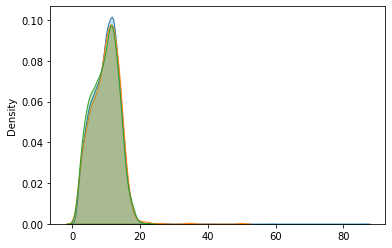

In [82]:
# get max length  to make padding
lenn =[]
for t in x_train:
  lenn.append(len(t))
sns.kdeplot(lenn,shade=True, label = "Train")
lenn =[]
for t in x_val:
  lenn.append(len(t))
sns.kdeplot(lenn,shade=True, label = "Validation")
lenn =[]
for t in x_test:
  lenn.append(len(t))
sns.kdeplot(lenn,shade=True, label = "Test")
plt.show()

In [83]:
# As maximum tokens in a row is 25
mx_len = 25
x_train = pad_sequences(x_train , maxlen = mx_len , padding="post")
x_val = pad_sequences(x_val , maxlen = mx_len  , padding="post")
x_test = pad_sequences(x_test , maxlen = mx_len  , padding="post")



In [84]:
# ONE-HOT ENCODING for y
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [85]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Activation, Flatten, Dropout

n_latent_factors = 20
model_2 = Sequential()
model_2.add(Embedding(vocab_sz+1 , n_latent_factors , input_length=mx_len)) 
model_2.add(Flatten())

model_2.add(Dense(20, activation="relu" ))
model_2.add(Dropout(0.2))

model_2.add(Dense(10 , activation="tanh"))


model_2.add(Dense(3 , activation="softmax"))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 20)            157760    
                                                                 
 flatten_3 (Flatten)         (None, 500)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                10020     
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dense_9 (Dense)             (None, 3)                 33        
                                                                 
Total params: 168,023
Trainable params: 168,023
Non-tr

In [86]:
model_2.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

history = model_2.fit(x_train,
                      y_train,
                      epochs=15,
                      batch_size=559,
                      validation_data=(x_val, y_val))


Epoch 1/15
22/22 [==============================] - 2s 30ms/step - loss: 0.6431 - accuracy: 0.5729 - val_loss: 0.5811 - val_accuracy: 0.6267
Epoch 2/15
22/22 [==============================] - 0s 15ms/step - loss: 0.5547 - accuracy: 0.6268 - val_loss: 0.5311 - val_accuracy: 0.6267
Epoch 3/15
22/22 [==============================] - 0s 15ms/step - loss: 0.5234 - accuracy: 0.6269 - val_loss: 0.5039 - val_accuracy: 0.6267
Epoch 4/15
22/22 [==============================] - 0s 14ms/step - loss: 0.4862 - accuracy: 0.6389 - val_loss: 0.4640 - val_accuracy: 0.6502
Epoch 5/15
22/22 [==============================] - 0s 14ms/step - loss: 0.4391 - accuracy: 0.6874 - val_loss: 0.4257 - val_accuracy: 0.6927
Epoch 6/15
22/22 [==============================] - 0s 14ms/step - loss: 0.3903 - accuracy: 0.7384 - val_loss: 0.3982 - val_accuracy: 0.7398
Epoch 7/15
22/22 [==============================] - 0s 14ms/step - loss: 0.3493 - accuracy: 0.7952 - val_loss: 0.3798 - val_accuracy: 0.7580
Epoch 8/15
22

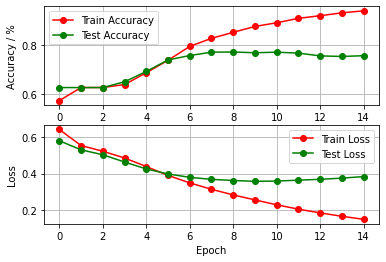

In [87]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['accuracy'], 'ro-', label = "Train Accuracy")
ax[0].plot(history.history['val_accuracy'], 'go-', label = "Test Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy / %")
ax[0].legend(loc = "best")
ax[0].grid('on')

ax[1].plot(history.history['loss'], 'ro-', label = "Train Loss")
ax[1].plot(history.history['val_loss'], 'go-', label = "Test Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc = "best")
ax[1].grid('on')
plt.show()

In [90]:

# Final evaluation of the model
scores = model_2.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {scores[1]}")

Accuracy: 0.7909836173057556
